In [1]:
! pip install git+https://github.com/openai/CLIP.git

from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
import os
import numpy as np
import clip as openai_clip
import torch
import torchvision
import torch.nn as nn
import torchvision.models as models
import torchvision.transforms as transforms
from torch.autograd import Variable
from PIL import Image

# !nvidia-smi

  Cloning https://github.com/openai/CLIP.git to /private/var/folders/gj/cy6x5zxs74j__yh6fwqs72500000gp/T/pip-req-build-qk8ky27p
  Running command git clone -q https://github.com/openai/CLIP.git /private/var/folders/gj/cy6x5zxs74j__yh6fwqs72500000gp/T/pip-req-build-qk8ky27p
  Resolved https://github.com/openai/CLIP.git to commit 04f4dc2ca1ed0acc9893bd1a3b526a7e02c4bb10


# Load Models

In [2]:
device = "cuda" if torch.cuda.is_available() else "cpu"
vgg16 = models.vgg16(pretrained=True)
resnet18 = models.resnet18(pretrained=True)
clip, preprocess = openai_clip.load("ViT-B/32", device=device, jit=False)

# Encode Images

In [4]:
def get_vgg_features(img):
  layer = vgg16._modules.get("classifier")[4]
  vgg16.eval()
  t_img = transforms(img)
  img_features = torch.zeros(4096)
  def copy_data(m, i, o):
    img_features.copy_(o.flatten())
  h = layer.register_forward_hook(copy_data)
  with torch.no_grad():
    vgg16(t_img.unsqueeze(0))  
  h.remove()
#   print(img_features)
  return img_features

def get_resnet_features(img):
  layer = resnet18._modules.get("avgpool")
  resnet18.eval()
  t_img = transforms(img)
  img_features = torch.zeros(512)
  def copy_data(m, i, o):
    img_features.copy_(o.flatten())
  h = layer.register_forward_hook(copy_data)
  with torch.no_grad():
    resnet18(t_img.unsqueeze(0))  
  h.remove()
#   print(img_features.shape)
  return img_features

def get_clip_features(img):
  img_features = clip.encode_image(preprocess(img).unsqueeze(0).to(device))
  img_features /= img_features.norm(dim=-1, keepdim=True)
#   print(img_features.shape)
  return img_features

root = "ikea/images/"

transforms = torchvision.transforms.Compose([
  torchvision.transforms.Resize(256),
  torchvision.transforms.CenterCrop(224),
  torchvision.transforms.ToTensor(),
  torchvision.transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

In [5]:
images = []
vgg_embeddings = []
resnet_embeddings = []
clip_embeddings = []

categories = []
for subdir, dirs, files in os.walk(root):
    for file in files:
        if not file.startswith('.'):
            img_path = os.path.join(subdir, file)
            img = Image.open(img_path).convert("RGB")
            cat_name = os.path.basename(subdir)
            if cat_name != "room_scenes":
                if len(images) % 10 == 0: print(len(images))
                images.append(np.array(img.resize((224, 224))))
                categories.append(cat_name)
                
#                 vgg_embeddings.append(get_vgg_features(img).detach().numpy())
#                 resnet_embeddings.append(get_resnet_features(img).detach().numpy())
#                 clip_embeddings.append(get_clip_features(img).detach().numpy())

images = np.stack(images)
categories = np.array(categories)
# vgg_embeddings = np.stack(vgg_embeddings)
# resnet_embeddings = np.stack(resnet_embeddings)
# clip_embeddings = np.stack(clip_embeddings)[:,0,:]

# os.mkdir("image-embeddings")
# np.save("image-embeddings/vgg_products.npy", vgg_embeddings)
# np.save("image-embeddings/resnet_products.npy", resnet_embeddings)
# np.save("image-embeddings/clip_products.npy", clip_embeddings)

0
10
20
30
40
50
60
70
80
90
100
110
120
130
140
150
160
170
180
190
200
210
220
230
240
250
260
270
280
290
300
310
320
330
340
350
360
370
380
390
400
410
420
430
440
450
460
470
480
490
500
510
520
530
540
550
560
570
580
590
600
610
620
630
640
650
660
670
680
690
700
710
720
730
740
750
760
770
780
790
800
810
820
830
840
850
860
870
880
890
900
910
920
930
940
950
960
970
980
990
1000
1010
1020
1030
1040
1050
1060
1070
1080
1090
1100
1110
1120
1130
1140
1150
1160
1170
1180
1190
1200
1210
1220
1230
1240
1250
1260
1270
1280
1290
1300
1310
1320
1330
1340
1350
1360
1370
1380
1390
1400
1410
1420
1430
1440
1450
1460
1470
1480
1490
1500
1510
1520
1530
1540
1550
1560
1570
1580
1590
1600
1610
1620
1630
1640
1650
1660
1670
1680
1690
1700
1710
1720
1730
1740
1750
1760
1770
1780
1790
1800
1810
1820
1830
1840
1850
1860
1870
1880
1890
1900
1910
1920
1930
1940
1950
1960
1970
1980
1990
2000
2010
2020
2030
2040
2050
2060
2070
2080
2090
2100
2110
2120
2130
2140
2150
2160
2170
2180
2190
2200
2210
2

In [6]:
vgg_embeddings = np.load("image-embeddings/vgg_products.npy")
resnet_embeddings = np.load("image-embeddings/resnet_products.npy")
clip_embeddings = np.load("image-embeddings/clip_products.npy")

In [15]:
clip_embeddings.shape

(2321, 512)

In [7]:
import emblaze

In [8]:
embeddings = emblaze.EmbeddingSet([
    emblaze.Embedding({
        emblaze.Field.POSITION: emb,
        emblaze.Field.COLOR: categories
    }, label=label, metric='cosine') for emb, label in zip([vgg_embeddings, resnet_embeddings, clip_embeddings],
                                          ['vgg', 'resnet', 'clip'])
])
embeddings

Embeddings are not 2D, skipping alignment


<EmbeddingSet with 3 embeddings:
	<Embedding with 2321 items, 2 fields (position, color)>
	<Embedding with 2321 items, 2 fields (position, color)>
	<Embedding with 2321 items, 2 fields (position, color)>>

In [9]:
embeddings.compute_neighbors(n_neighbors=100)

In [10]:
reduced = embeddings.project(method=emblaze.ProjectionTechnique.ALIGNED_UMAP)
reduced

OMP: Info #271: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.
/Users/vsivaram/anaconda3/envs/mmml/lib/python3.9/site-packages/umap/umap_.py:905: RuntimeWarning: overflow encountered in true_divide
  result[n_samples > 0] = float(n_epochs) / n_samples[n_samples > 0]
/Users/vsivaram/anaconda3/envs/mmml/lib/python3.9/site-packages/umap/umap_.py:905: RuntimeWarning: overflow encountered in true_divide
  result[n_samples > 0] = float(n_epochs) / n_samples[n_samples > 0]


<EmbeddingSet with 3 embeddings:
	<Embedding with 2321 items, 3 fields (position, color, highlight)>
	<Embedding with 2321 items, 3 fields (position, color, highlight)>
	<Embedding with 2321 items, 3 fields (position, color, highlight)>>

In [11]:
thumbnails = emblaze.ImageThumbnails(images)

In [12]:
w = emblaze.Viewer(embeddings=reduced, thumbnails=thumbnails)
w

Viewer(colorScheme='tableau', data={'data': [{'_format': 'compressed', '_idtype': 'u2', '_length': 2321, 'ids'…

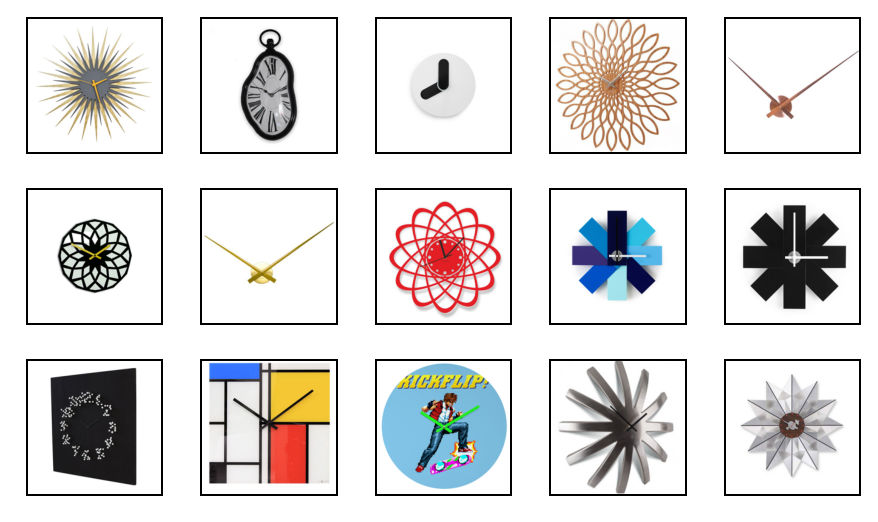

In [64]:
ids = w.selectedIDs
plt.figure(figsize=(5, 3), dpi=180)
for i, id_val in enumerate(ids):
    plt.subplot(3, 5, i + 1)
    plt.imshow(thumbnails.image(id_val))
    plt.xticks([])
    plt.yticks([])
plt.tight_layout()
plt.show()

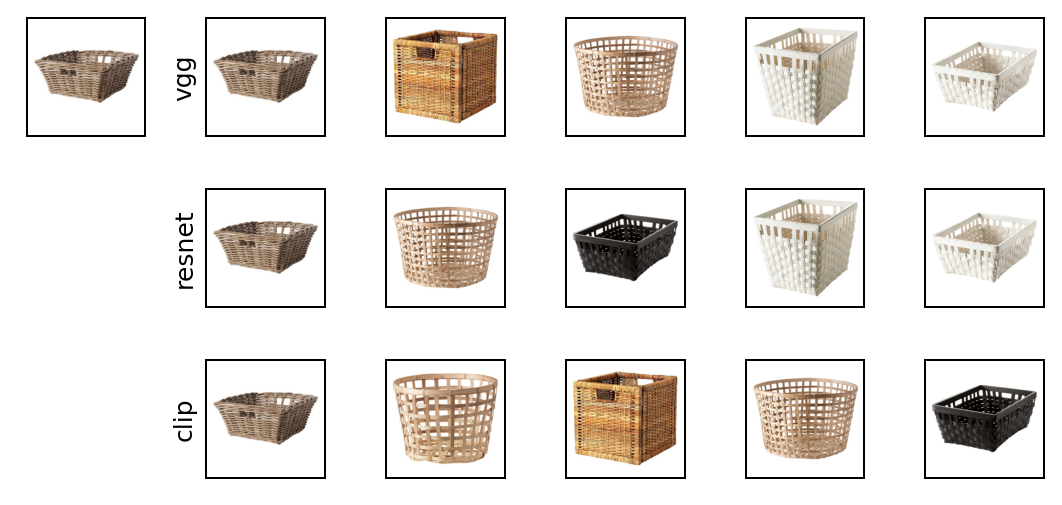

In [61]:
# Do any of these embedding spaces encode style?
ids = w.selectedIDs
class_label = emb.field(emblaze.Field.COLOR, ids[0])
find_class_labels = set(["chair", "dining table", "bed", "objects"])

plt.figure(figsize=(6, 3), dpi=180)
for emb_idx in range(3):
    emb = reduced[emb_idx]
    
    # Find the nearest neighbors that are NOT of the same class
    neighbors = list(set([i for i in emb.field(emblaze.Field.NEIGHBORS, ids).T.flatten() if emb.field(emblaze.Field.COLOR, i) in find_class_labels][:5]))

    if emb_idx == 0:
        plt.subplot(3, 6, 1)
        plt.imshow(thumbnails.image(ids[0]))
        plt.xticks([])
        plt.yticks([])
    for i, id_val in enumerate(neighbors):
        plt.subplot(3, 6, emb_idx * 6 + i + 2)
        plt.imshow(thumbnails.image(id_val))
        plt.xticks([])
        plt.yticks([])
        if i == 0:
            plt.ylabel(emb.label)

plt.tight_layout()
plt.show()

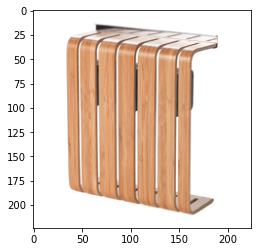

In [54]:
plt.imshow(thumbnails.image(ids[0]))